In [1]:

import numpy as np
import matplotlib.pyplot as plt
# If you need to import from a local utils.py, uncomment and adjust the following lines:
import sys
import os
import jax.numpy as jnp
# Construct the full path to the folder
folder_path = r'C:\Users\Petrb\Desktop\DTU\3rdSemester\02477_BAYESIAN_MACHINE_LEARNING'

# Add the folder to the Python path
sys.path.append(folder_path)

# Now you can import the utils module
from EXAMS.EXAM_2024.Task_2.utils import *

import numpy as np
import matplotlib.pyplot as plt


## Part 4: A generalized linear model

Consider the generalized linear model:

$$
y_n \mid x_n, \mathbf{w} \sim \text{Poisson}(\mu(x_n)),
$$

$$
\mu(x_n) = \exp(3 + w_1 x_n + w_2 x_n^2)
$$

$$
\mathbf{w} \mid \alpha \sim \mathcal{N}(\mathbf{0}, \alpha^{-1} \mathbf{I}),
$$

where $x_n \in \mathbb{R}$ is an input with corresponding target $y_n \in \{0, 1, 2, \dots \}$, and $\mathbf{w} = \begin{bmatrix} w_1 \\ w_2 \end{bmatrix}$ are the parameters of interest, $\alpha = 8$ is a fixed hyperparameter, and $\mathbf{I}$ is the identity matrix.

The plots below show the prior, the likelihood, and the posterior, respectively, for the following dataset with $N = 3$ observations:

$$
\mathbf{x} = \begin{bmatrix} 1 & 2 & 3 \end{bmatrix}, \quad
\mathbf{y} = \begin{bmatrix} 10 & 4 & 1 \end{bmatrix},
$$

such that $x_n$ and $y_n$ are the $n$'th elements in $\mathbf{x}$ and $\mathbf{y}$, respectively.

---


---

### Question 4.1

Use Figure 1 to visually identify (approximately) and report the maximum likelihood estimator and the MAP estimator for $\mathbf{w}$.

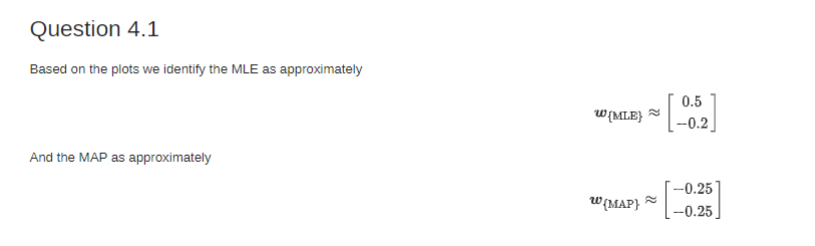

### Question 4.2

Compute the prior mean of $\mu(x^*)$ for $x^* = 0$.

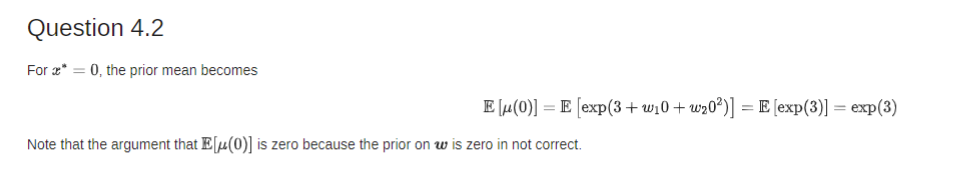

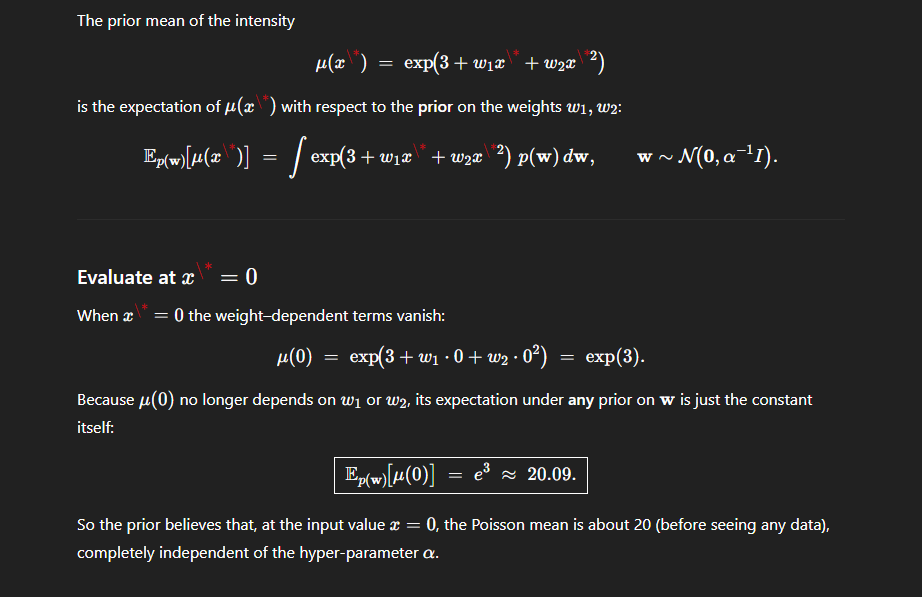

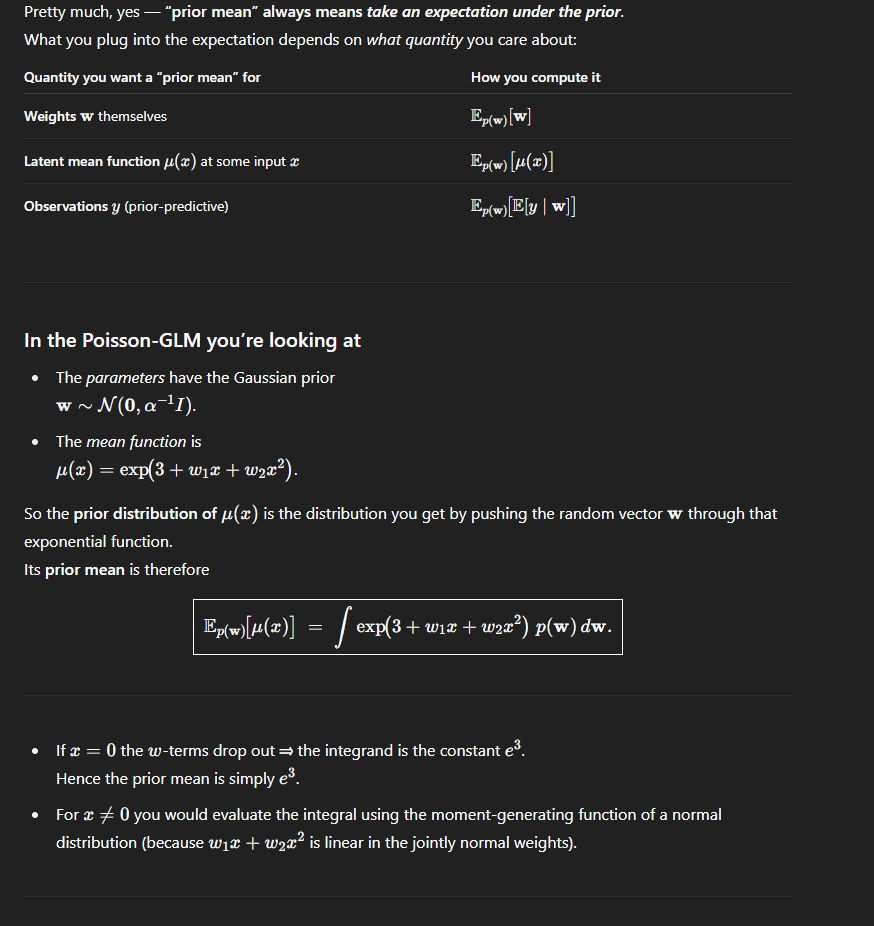

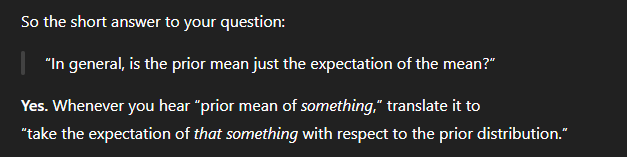


---
### Question 4.3

Run a single MCMC chain using the Metropolis algorithm for $10^4$ iterations using a standardized Gaussian as proposal distribution. Initialize the chain at $(w_1, w_2) = (0, 0)$. Discard 50% of the samples as warm up. Plot the resulting traces for both parameters.



In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
from jax import random
import seaborn as snb

# style stuff
snb.set_style('darkgrid')
snb.set(font_scale=1.25)

def metropolis(log_target, num_params, tau, num_iter, theta_init=None, seed=0):    
    """ Runs a Metropolis-Hastings sampler 
    
        Arguments:
        log_target:         function for evaluating the log target distribution, i.e. log \tilde{p}(theta). The function expect a parameter of size num_params.
        num_params:         number of parameters of the joint distribution (integer)
        tau:                standard deviation of the Gaussian proposal distribution (positive real)
        num_iter:           number of iterations (integer)
        theta_init:         vector of initial parameters (np.array with shape (num_params) or None)        
        seed:               seed (integer)

        returns
        thetas              np.array with MCMC samples (np.array with shape (num_iter+1, num_params))
    """ 
    
    # set initial key
    key = random.PRNGKey(seed)

    if theta_init is None:
        theta_init = jnp.zeros((num_params))
    
    # prepare lists 
    thetas = [theta_init]
    accepts = []
    log_p_theta = log_target(theta_init)
    
    for k in range(num_iter):

        # update keys: key_proposal for sampling proposal distribution and key_accept for deciding whether to accept or reject.
        key, key_proposal, key_accept = random.split(key, num=3)

        ##############################################
        # Your solution goes here
        ##############################################
        

        # get the last value for theta and generate new proposal candidate
        theta_cur = thetas[-1]
        theta_star = theta_cur + tau*random.normal(key_proposal, shape=(num_params, ))
        
        # evaluate the log density for the candidate sample
        log_p_theta_star = log_target(theta_star)

        # compute acceptance probability
        log_r = log_p_theta_star - log_p_theta
        A = min(1, jnp.exp(log_r))
        
        # accept new candidate with probability A
        if random.uniform(key_accept) < A:
            theta_next = theta_star
            log_p_theta = log_p_theta_star
            accepts.append(1)
        else:
            theta_next = theta_cur
            accepts.append(0)


        
        ##############################################
        # End of solution
        ##############################################
            
        thetas.append(theta_next)


        
    print('Acceptance ratio: %3.2f' % jnp.mean(jnp.array(accepts)))
        
    # return as np.array
    thetas = jnp.stack(thetas)

    # check dimensions and return
    assert thetas.shape == (num_iter+1, num_params), f'The shape of thetas was expected to be ({num_iter+1}, {num_params}), but the actual shape was {thetas.shape}. Please check your code.'
    return thetas, jnp.mean(jnp.array(accepts))

Acceptance ratio: 0.04


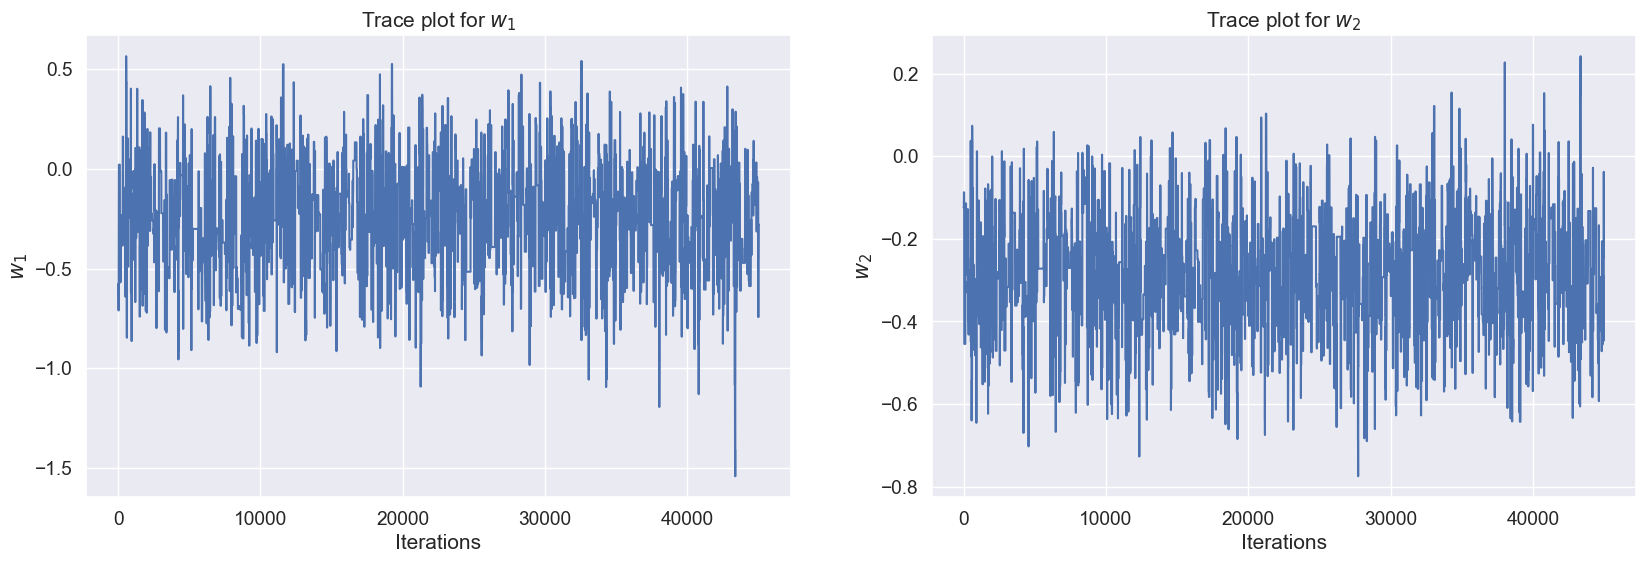

In [11]:
# -------------------------------------------------------------------
# Imports
# -------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, multivariate_normal as mvn

# -------------------------------------------------------------------
# 1.  Data and model hyper-parameters
# -------------------------------------------------------------------
x = np.array([1.0, 2.0, 3.0])        # three input points  (shape: 3,)
y = np.array([10, 4, 1])             # corresponding Poisson counts (shape: 3,)
alpha = 8                             # precision (inverse variance) of the Gaussian prior

# -------------------------------------------------------------------
# 2.  Build the design matrix  X = [ x , x^2 ]
#     Each row corresponds to one observation; each column to a feature.
# -------------------------------------------------------------------
X = np.column_stack((x, x**2))        # shape: (3 observations, 2 features)

# -------------------------------------------------------------------
# 3.  Log-joint density   log p(y, w) = log p(w) + log p(y | w)
#     -----------------------------------------------------------
#     • Prior:     w ~ N(0, (1/alpha) I)
#     • Likelihood: y_n | w  ~  Poisson( μ_n )  with
#                   μ_n = exp( 3 + w1 * x_n + w2 * x_n^2 )
# -------------------------------------------------------------------
def log_joint(w: np.ndarray) -> float:
    """
    Compute log p(w) + log p(y | w).

    Parameters
    ----------
    w : array of shape (2,)
        Current value of the parameter vector [w1, w2].

    Returns
    -------
    float
        The log-joint probability of (y, w).
    """
    # ----- Likelihood term -----
    mu = np.exp(3 + X @ w)            # vector μ = exp(3 + Xw)   shape: (3,)
    log_lik = poisson.logpmf(y, mu).sum()

    # ----- Prior term -----
    #   For a diagonal covariance (1/alpha) I, scipy's logpdf expects the full matrix.
    log_prior = mvn.logpdf(w,
                           mean=np.zeros(2),
                           cov=(1 / alpha) * np.identity(2))

    return log_prior + log_lik

# -------------------------------------------------------------------
# 4.  Metropolis sampler
#     ---------------------------------------------------------------
#     You apparently have a function `metropolis(...)` that
#     • proposes w' = w + N(0, τ² I)
#     • accepts / rejects with the standard Metropolis rule.
#     Here we call it for 50 000 iterations, keeping both parameters.
# -------------------------------------------------------------------
samples, accept = metropolis(
    log_joint,             # target log density
    num_params=2,          # dimension of w
    tau=1.0,               # proposal std-dev  (jump size)
    num_iter=50_000,       # total draws
    theta_init=np.array([0.0, 0.0])   # start at prior mean
)

# -------------------------------------------------------------------
# 5.  Discard the first 5 000 draws as “warm-up / burn-in”
# -------------------------------------------------------------------
samples = samples[5_000:, :]          # shape: (45 000, 2)

# -------------------------------------------------------------------
# 6.  Trace plots to diagnose mixing of each parameter
# -------------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
param_names = [r'$w_1$', r'$w_2$']

for i in range(2):
    ax[i].plot(samples[:, i])
    ax[i].set(
        xlabel='Iteration',
        ylabel=param_names[i],
        title=f'Trace plot for {param_names[i]}'
    )

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# End of script
# -------------------------------------------------------------------


Use the posterior samples of $\mathbf{w}$ from Question 4.4 to answer the next two questions. If you did not solve the previous question, you can draw $10^4$ samples of $\mathbf{w}$ as:

$$
\mathbf{w} \sim \mathcal{N} \left(
\begin{bmatrix} -1 \\ -1 \end{bmatrix}, \quad
\begin{bmatrix}
1 & -0.1 \\
-0.1 & 0.5
\end{bmatrix}
\right) \tag{12}
$$

and assume these are samples from the correct posterior distribution when solving the next two questions.


### Question 4.4

Estimate the posterior probability that $w_1$ is positive using the samples.

In [12]:
print(f'p(w_1 > 0|y) = {np.mean(samples[:, 0] > 0):3.2f}')

p(w_1 > 0|y) = 0.18




Consider now the test point $x^* = 1.5$.

### Question 4.5

Estimate posterior probability that $\mu^* = \mu(x^*)$ is greater than 7 using the posterior samples.

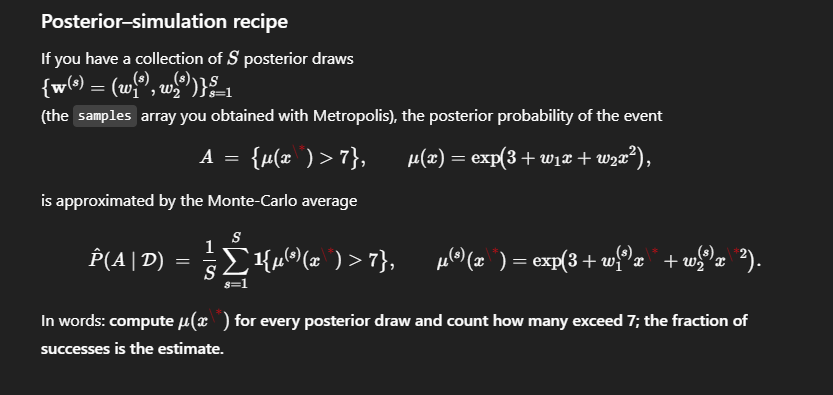



In [24]:
xstar = 1.5
mu_samples = np.exp(3 + samples[:, 0]*xstar + samples[:, 1]*xstar**2)
print(f'p(mu^* > 7|y) = {np.mean(mu_samples > 7):3.2f}')

p(mu^* > 7|y) = 0.59


In [26]:
# x* whose intensity you want to evaluate
x_star = 0.0          # <-- change to the value specified in your assignment

# posterior samples from the Metropolis run (after warm-up)
w1 = samples[:, 0]    # shape: (S,)
w2 = samples[:, 1]

# μ(x*) for every posterior draw
mu_star = np.exp(3 + samples[:, 0] * x_star + samples[:, 1] * x_star**2)

# indicator: 1 if μ(x*) > 7, else 0
indicator = (mu_star > 7)

# Monte-Carlo estimate of P[ μ(x*) > 7 | data ]
probability = indicator.mean()

print(f"Estimated posterior probability that μ(x*) > 7: {probability:.3f}")


Estimated posterior probability that μ(x*) > 7: 1.000


---

### Question 4.6

Compute an approximate 90% posterior credibility interval for $p(y^* \mid \mathbf{y}, x^*)$ using the posterior samples.

In [14]:
y_samples = np.random.poisson(mu_samples)
np.percentile(mu_samples, [5, 95])

array([ 5.09121466, 10.51613808])